In [103]:
import networkx as nx
import pandas as pd
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import numpy as np
import scipy as sp
from networkx.algorithms.centrality import betweenness_centrality
import matplotlib.pyplot as plt


In [104]:
############################
# RELEVANT ISO CODES
############################

hs_codes = [

    ############################
    # Gold -> Baseline
    ############################
    710812,

    ############################
    # Medicine and Antibiotics -> Baseline
    ############################
    300490, 294190,

    ############################
    # Aluminium
    ############################
    760110,

    ############################
    # Energy: Oil and Coal
    ############################
    270900, 270112,

    ############################
    # Semiconductors
    ############################
    853400
]

In [105]:
imported_graphs = {}

for product_code in hs_codes:
    file_path = f"./sandrin_export/{product_code}_graph.graphml"

    imported_graphs[product_code] = nx.read_graphml(file_path)
    print(f"Successfully imported graph for product code {product_code}.")


Successfully imported graph for product code 710812.
Successfully imported graph for product code 300490.
Successfully imported graph for product code 294190.
Successfully imported graph for product code 760110.
Successfully imported graph for product code 270900.
Successfully imported graph for product code 270112.
Successfully imported graph for product code 853400.


In [106]:
def extract_yearly_subgraphs(G, years):
    yearly_subgraphs = {}
    for year in years:
        yearly_edges = [
            (u, v, k) for u, v, k, d in G.edges(keys=True, data=True)
            if d.get('year') == year
        ]
        yearly_subgraphs[year] = G.edge_subgraph(yearly_edges).copy()
    return yearly_subgraphs


years = range(2002, 2023)
product_code = 710812
yearly_graphs = extract_yearly_subgraphs(imported_graphs[product_code], years)

for year, graph in yearly_graphs.items():
    print(f"Year: {year}, Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")


Year: 2002, Nodes: 146, Edges: 763
Year: 2003, Nodes: 152, Edges: 814
Year: 2004, Nodes: 146, Edges: 864
Year: 2005, Nodes: 157, Edges: 921
Year: 2006, Nodes: 150, Edges: 900
Year: 2007, Nodes: 162, Edges: 1018
Year: 2008, Nodes: 162, Edges: 1099
Year: 2009, Nodes: 164, Edges: 1084
Year: 2010, Nodes: 167, Edges: 1193
Year: 2011, Nodes: 169, Edges: 1284
Year: 2012, Nodes: 182, Edges: 1437
Year: 2013, Nodes: 183, Edges: 1472
Year: 2014, Nodes: 183, Edges: 1395
Year: 2015, Nodes: 189, Edges: 1447
Year: 2016, Nodes: 188, Edges: 1482
Year: 2017, Nodes: 181, Edges: 1514
Year: 2018, Nodes: 184, Edges: 1487
Year: 2019, Nodes: 189, Edges: 1604
Year: 2020, Nodes: 182, Edges: 1538
Year: 2021, Nodes: 188, Edges: 1599
Year: 2022, Nodes: 187, Edges: 1684


In [107]:
def compute_func_over_time(yearly_graphs, func):
    centrality_data = []
    for year, G in yearly_graphs.items():
        centralities = func(G)
        for node, centrality in centralities.items():
            centrality_data.append({'node': node, 'year': year, func.__name__: centrality})
    return pd.DataFrame(centrality_data)


In [108]:
def plot_func_trends(centrality_df, top_n, func_name):
    top_nodes = (
        centrality_df.groupby('node')[func_name]
        .mean()
        .nlargest(top_n)
        .index
    )
    filtered_df = centrality_df[centrality_df['node'].isin(top_nodes)]
    pivot_df = filtered_df.pivot(index='year', columns='node', values=func_name)
    pivot_df.plot(figsize=(10, 6), marker='o')
    plt.title(f'{func_name} Trends Over Time')
    plt.xlabel('Year')
    plt.ylabel(func_name.title())
    plt.legend(title='Node')
    plt.grid()
    plt.show()


In [109]:
def process_visualization(yearly_graphs, func, top_n=5):
    centrality_df = compute_func_over_time(yearly_graphs, func)
    plot_func_trends(centrality_df, top_n, func.__name__)

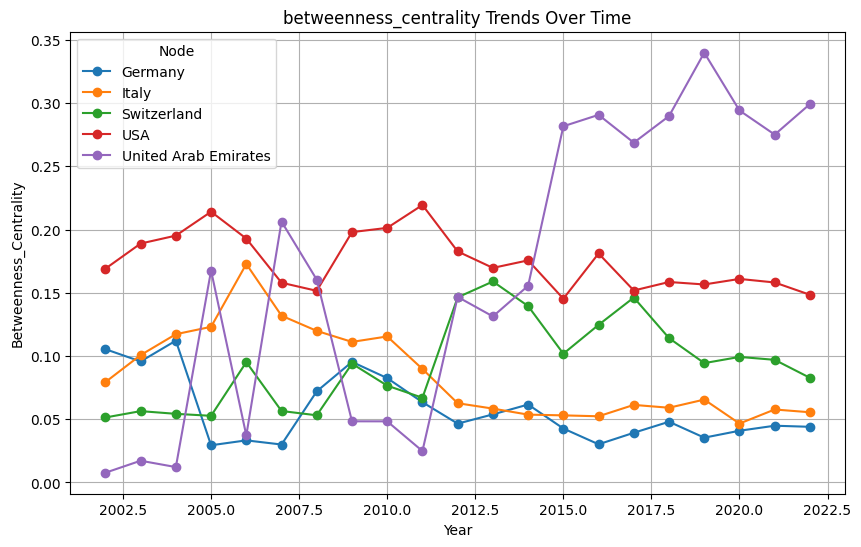

In [110]:
func = nx.betweenness_centrality
process_visualization(yearly_graphs, func, top_n=5)

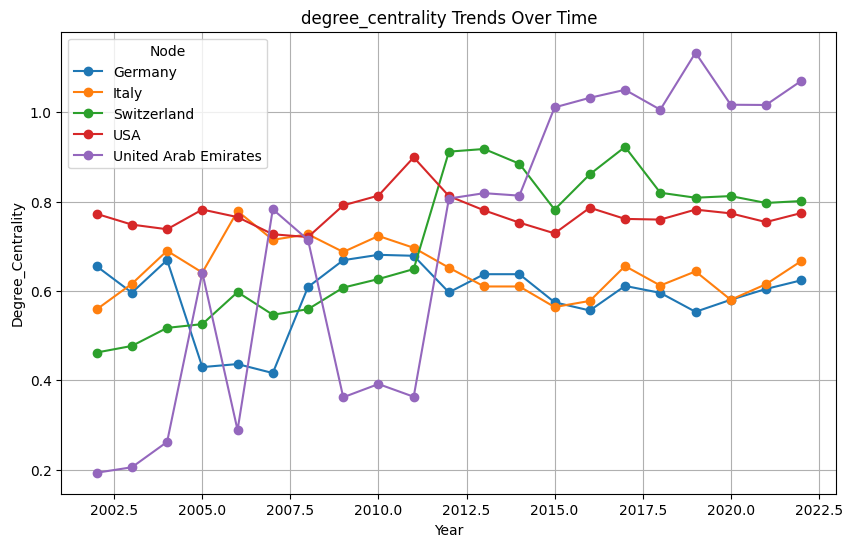

In [111]:
func = nx.degree_centrality
process_visualization(yearly_graphs, func, top_n=5)

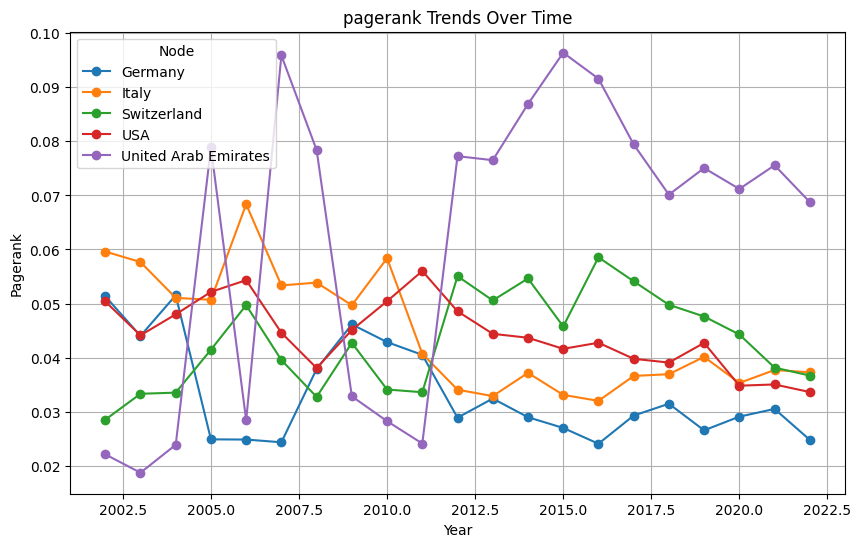

In [112]:
method = nx.pagerank
process_visualization(yearly_graphs, method, top_n=5)


Year: 2002, Nodes: 146, Edges: 763, Density: 0.0360
Year: 2003, Nodes: 152, Edges: 814, Density: 0.0355
Year: 2004, Nodes: 146, Edges: 864, Density: 0.0408
Year: 2005, Nodes: 157, Edges: 921, Density: 0.0376
Year: 2006, Nodes: 150, Edges: 900, Density: 0.0403
Year: 2007, Nodes: 162, Edges: 1018, Density: 0.0390
Year: 2008, Nodes: 162, Edges: 1099, Density: 0.0421
Year: 2009, Nodes: 164, Edges: 1084, Density: 0.0406
Year: 2010, Nodes: 167, Edges: 1193, Density: 0.0430
Year: 2011, Nodes: 169, Edges: 1284, Density: 0.0452
Year: 2012, Nodes: 182, Edges: 1437, Density: 0.0436
Year: 2013, Nodes: 183, Edges: 1472, Density: 0.0442
Year: 2014, Nodes: 183, Edges: 1395, Density: 0.0419
Year: 2015, Nodes: 189, Edges: 1447, Density: 0.0407
Year: 2016, Nodes: 188, Edges: 1482, Density: 0.0422
Year: 2017, Nodes: 181, Edges: 1514, Density: 0.0465
Year: 2018, Nodes: 184, Edges: 1487, Density: 0.0442
Year: 2019, Nodes: 189, Edges: 1604, Density: 0.0451
Year: 2020, Nodes: 182, Edges: 1538, Density: 0.046

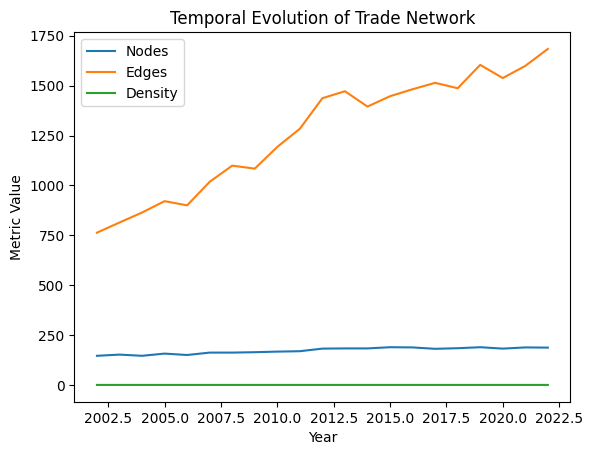

In [113]:

def analyze_yearly_subgraphs(yearly_graphs):
    evolution_metrics = []

    for year, graph in yearly_graphs.items():

        num_nodes = graph.number_of_nodes()
        num_edges = graph.number_of_edges()
        density = nx.density(graph)
        degree_dist = [d for n, d in graph.degree()]
        avg_degree = sum(degree_dist) / num_nodes if num_nodes > 0 else 0

        # Centrality (you can compute other centralities as needed)
        betweenness = betweenness_centrality(graph)
        top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

        # Store metrics
        evolution_metrics.append({
            'year': year,
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'density': density,
            'avg_degree': avg_degree,
            'top_betweenness': top_betweenness
        })

        print(f"Year: {year}, Nodes: {num_nodes}, Edges: {num_edges}, Density: {density:.4f}")

    return evolution_metrics

metrics = analyze_yearly_subgraphs(yearly_graphs)

# Plot the temporal evolution of key metrics
years = [m['year'] for m in metrics]
nodes = [m['num_nodes'] for m in metrics]
edges = [m['num_edges'] for m in metrics]
density = [m['density'] for m in metrics]

plt.figure()
plt.plot(years, nodes, label='Nodes')
plt.plot(years, edges, label='Edges')
plt.plot(years, density, label='Density')
plt.xlabel('Year')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Temporal Evolution of Trade Network')
plt.show()
